In [1]:
import eli5
from IPython.display import display, HTML
import shap
import pandas as pd
import numpy as np
from joblib import load
import matplotlib.pyplot as plt
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
log_reg_model = load('C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/ml-xai/logistic_regression_model.pkl')
dt_model = load('C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/ml-xai/decision_tree_model.pkl')

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<font color="bluegrey" size=+1.0><b>Preprocess</b></font>

In [3]:
train_data = pd.read_csv('train_data.csv')
X_train = train_data.drop(columns=['stroke'])
y_train = train_data['stroke']

test_data = pd.read_csv('test_data.csv')
X_test = test_data.drop(columns=['stroke'])
y_test = test_data['stroke']

# === Define column types ===
categorical_columns = ['work_type', 'smoking_status', 'bmi_category']
numerical_columns = ['age', 'avg_glucose_level', 'gender', 'ever_married', 'Residence_type']

# === Preprocessing function ===
def preprocess_data(X_train, X_test, categorical_columns, numerical_columns):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
        ]
    )
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    X_train_processed = pipeline.fit_transform(X_train)
    X_test_processed = pipeline.transform(X_test)
    
    print(f"Processed Training Data Shape: {X_train_processed.shape}")
    print(f"Processed Testing Data Shape: {X_test_processed.shape}")
    
    return X_train_processed, X_test_processed, pipeline

# === Preprocess data ===
X_train_processed, X_test_processed, pipeline = preprocess_data(X_train, X_test, categorical_columns, numerical_columns)

# === Apply SMOTE on preprocessed data ===
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

print("Original dataset shape:", X_train_processed.shape, "Target distribution:", y_train.value_counts().to_dict())
print("Balanced dataset shape:", X_train_balanced.shape, "Target distribution:", dict(pd.Series(y_train_balanced).value_counts()))

Processed Training Data Shape: (4087, 18)
Processed Testing Data Shape: (1022, 18)
Original dataset shape: (4087, 18) Target distribution: {0: 3888, 1: 199}
Balanced dataset shape: (7776, 18) Target distribution: {0: 3888, 1: 3888}


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


<font color="bluegrey" size=+1.0><b>Logistic Regression</b></font>

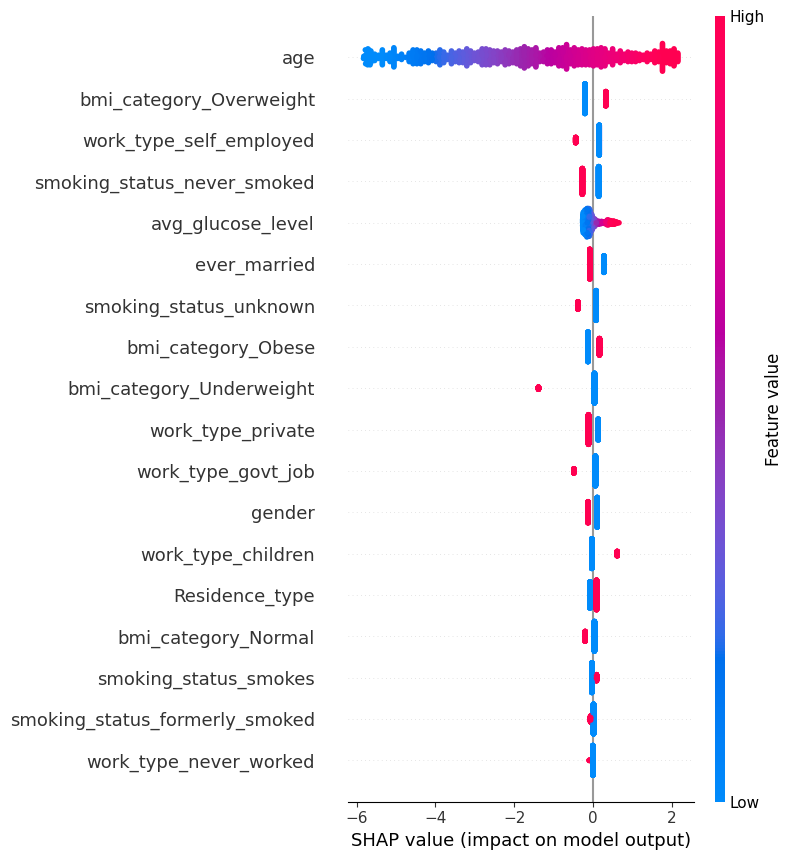

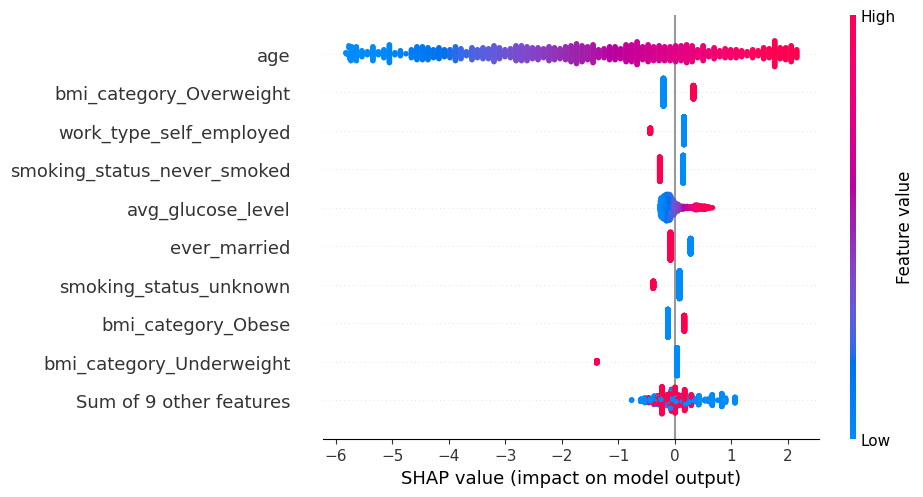

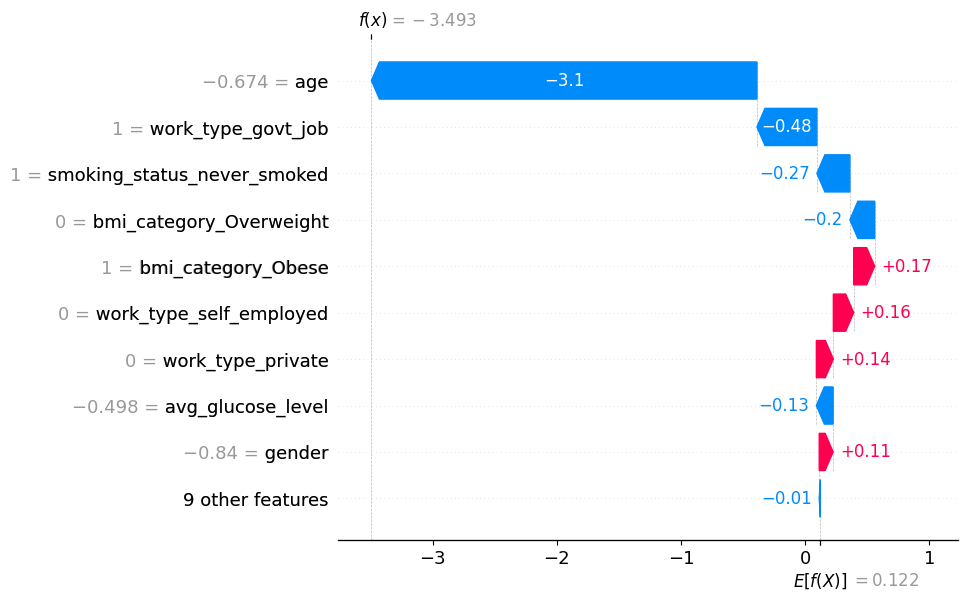

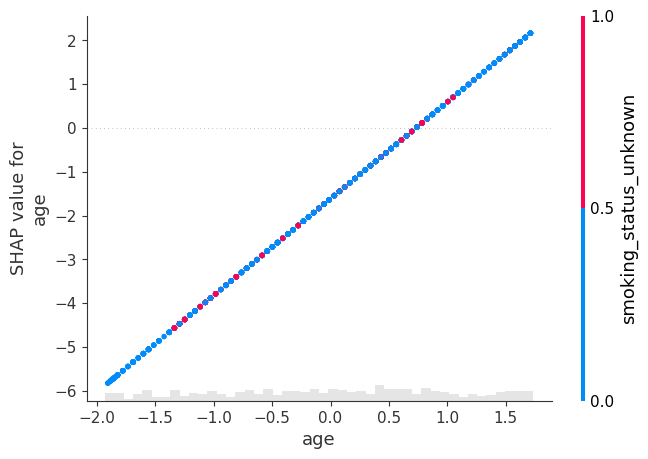

In [4]:
# === Logistic Regression Model ===
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_balanced, y_train_balanced)

# === Predictions ===
y_pred_logreg = log_reg_model.predict(X_test_processed)
y_pred_prob_logreg = log_reg_model.predict_proba(X_test_processed)[:, 1]

# === Extract Clean Feature Names ===
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
clean_feature_names = [name.split('__')[-1] for name in feature_names]

# === SHAP Analysis (Global + Local) ===
explainer = shap.Explainer(log_reg_model, X_train_balanced, feature_names=clean_feature_names)
shap_values = explainer(X_test_processed)

# === Global Explanation ===
shap.summary_plot(shap_values, X_test_processed, feature_names=clean_feature_names)
shap.plots.beeswarm(shap_values)

# === Local Explanation for an Instance ===
shap.plots.waterfall(shap_values[0])
shap.plots.scatter(shap_values[:, "age"], color=shap_values)

# === LIME Explanation ===
lime_explainer = LimeTabularExplainer(
    training_data=X_train_balanced,
    training_labels=y_train_balanced,
    feature_names=clean_feature_names,
    class_names=['No Stroke', 'Stroke'],
    mode='classification',
    discretize_continuous=True
)

instance_to_explain = X_test_processed[0]

lime_exp = lime_explainer.explain_instance(
    instance_to_explain,
    log_reg_model.predict_proba,
    num_features=10
)

lime_exp.show_in_notebook()

# === ELI5 Explanation ===
# Global (weights)
explanation = eli5.show_weights(log_reg_model, feature_names=clean_feature_names, top=10)

# Convert the explanation to HTML
explanation_html = explanation.data

# Apply custom styles directly within the HTML
# Custom CSS for better readability
custom_css = """
<style>
    .eli5 {
        background-color: #FFFFFF !important;  /* White background */
        color: #333333 !important;             /* Dark text color */
        font-family: 'Arial', sans-serif !important;
    }
    .eli5 .feature-weights table {
        background-color: #F5F5F5 !important; /* Light background for tables */
        border: 1px solid #D0D0D0 !important; /* Light gray border */
    }
    .eli5 .feature-weights td, .eli5 .feature-weights th {
        padding: 10px !important;
        color: #333333 !important; /* Dark text */
        font-size: 14px !important; /* Better font size */
    }
    .eli5 .feature-weights th {
        background-color: #E8E8E8 !important; /* Light gray for headers */
    }
    .eli5 .feature-weights .highlight {
        color: #000000 !important;  /* Black text for highlights */
        background-color: #FFD700 !important;  /* Gold background for highlights */
    }
</style>
"""

# Display the explanation with custom CSS
display(HTML(custom_css + explanation_html))

# Local (instance) explanation
explanation_local = eli5.show_prediction(log_reg_model, instance_to_explain, feature_names=clean_feature_names)

# Convert local explanation to HTML
explanation_local_html = explanation_local.data

# Display the local explanation with custom CSS
display(HTML(custom_css + explanation_local_html))

<font color="bluegrey" size=+1.0><b>Decision Trees</b></font>

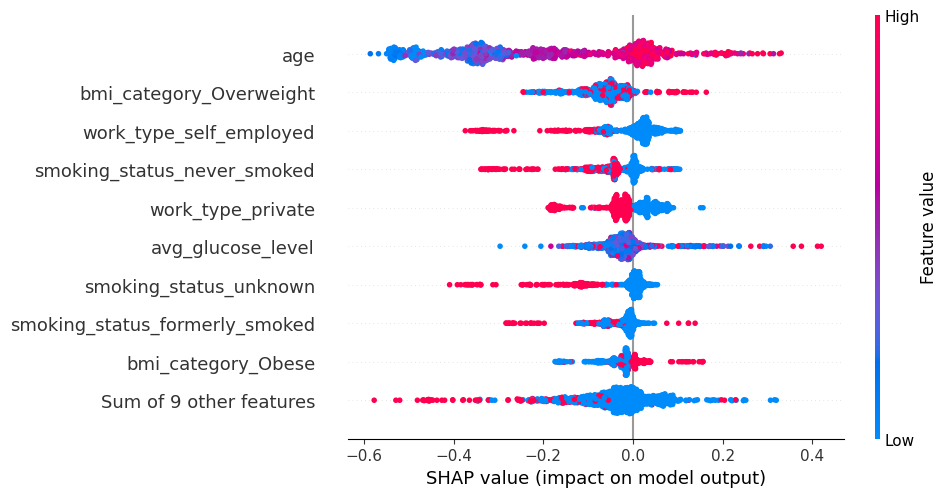

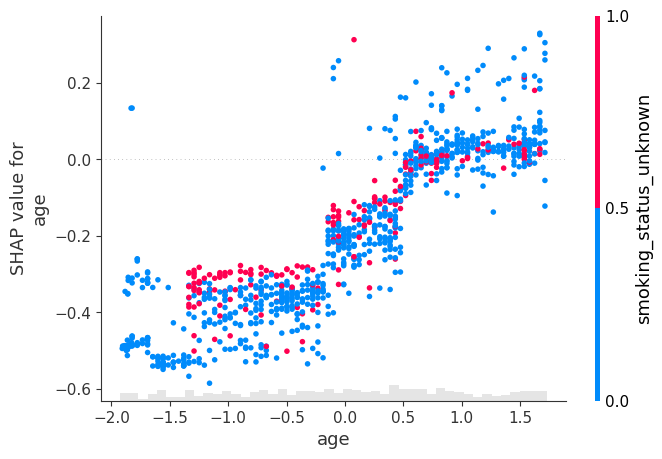

Weight,Feature
0.4767,age
0.1475,avg_glucose_level
0.0672,smoking_status_never_smoked
0.0390,smoking_status_formerly_smoked
0.0336,smoking_status_unknown
0.0333,bmi_category_Overweight
0.0325,work_type_self_employed
0.0308,bmi_category_Obese
0.0294,work_type_govt_job
0.0250,Residence_type


In [19]:
# === Decision Tree Model ===
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_balanced, y_train_balanced)

# === Predictions ===
y_pred_dt = dt_model.predict(X_test_processed)
y_pred_prob_dt = dt_model.predict_proba(X_test_processed)[:, 1]

# === Extract Clean Feature Names ===
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
clean_feature_names = [name.split('__')[-1] for name in feature_names]

# === SHAP Analysis (Global + Local) ===
explainer = shap.Explainer(dt_model, X_train_balanced, feature_names=clean_feature_names)
shap_values = explainer(X_test_processed)

# === Global Explanation ===
clean_feature_names = np.array(clean_feature_names)
shap_values_class_1 = shap_values[..., 1]

shap.plots.beeswarm(shap_values_class_1)

# === Local Explanation for an Instance ===
age_index = np.where(clean_feature_names == "age")[0][0]
shap.plots.scatter(shap_values_class_1[:, age_index], color=shap_values_class_1)

# === LIME Explanation ===
lime_explainer = LimeTabularExplainer(
    training_data=X_train_balanced,
    training_labels=y_train_balanced,
    feature_names=clean_feature_names,
    class_names=['No Stroke', 'Stroke'],
    mode='classification',
    discretize_continuous=True
)

instance_to_explain = X_test_processed[0]

lime_exp = lime_explainer.explain_instance(
    instance_to_explain,
    dt_model.predict_proba,
    num_features=10
)

lime_exp.show_in_notebook()

# === ELI5 Explanation ===

# Global explanation (tree rules)
explanation = eli5.explain_weights_sklearn(dt_model, feature_names=clean_feature_names, top=10)
display(HTML(custom_css + eli5.format_as_html(explanation)))

# === Local explanation (for predicted class only) ===
explanation_local = eli5.explain_prediction(
    dt_model,
    instance_to_explain,
    feature_names=clean_feature_names,
    target_names=['No Stroke', 'Stroke'],
    top=10
)
explanation_local_html = eli5.format_as_html(explanation_local)
display(HTML("<h3>Prediction Explanation for Predicted Class</h3>" + custom_css + explanation_local_html))